# Vehicle Occupant Pose Data Machine Learning Analysis
**Class: IT480 - Autonomous Vehicles**

**Author: Daniel Hassler**

**Version: 3/3/23**

In [ ]:
import numpy as np
import sklearn
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn import tree
import matplotlib.pyplot as plt
from passengerclassifier import PassengerRFClassifier, PassengerData


: 

In [3]:
prfc = PassengerRFClassifier.load_model("./saved_models/passengerRF_model_113")
y_pred = prfc.predict(prfc.X_test)

## Data Analysis

### Background on the Data
The data used to train our model originated directly from the ZED2i camera facing the vehicle occupants of the golf cart, and was automatically collected through ROS callbacks with some manual tweaks. Here is the skeleton_3d data that's obtained (so far):
- There are 16,000+ entries of shape (18, 3)
- 10,000+ entries for SAFE poses equally distributed between driver, middle, and passenger side.  
- 6,900+ entries for UNSAFE poses equally distributed between driver and passenger side.

In order to train the RandomForestClassifier, the shape of the data needed to be reshaped from (num_entries, 18, 3) to (num_entries, 54).

### Skeleton3d Data

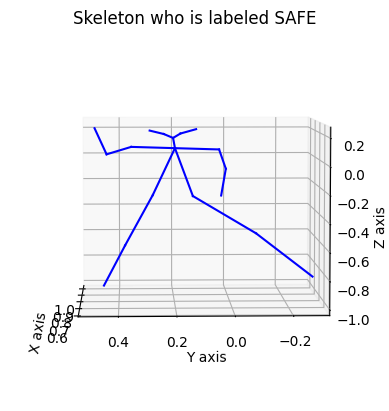

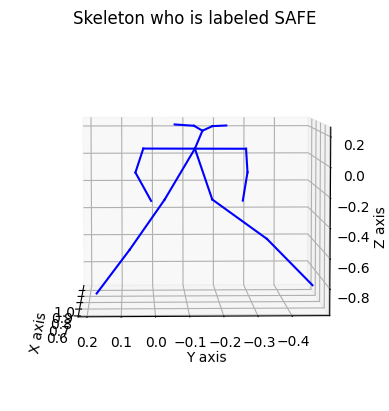

In [4]:
def plot_skeleton(X, y, person_ind):
    person = X[person_ind].reshape(18, 3)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    connections = [[0, 1], [1, 2], [1, 5], [1, 11], 
                [1, 8], [2, 3], [3, 4], [5, 6], 
                [6, 7], [8, 9], [9, 10], [11, 12], 
                [12, 13], [0, 14], [14, 16], 
                [0, 15], [15, 17]]

    for connection in connections:
        joint_one_ind = connection[0]
        joint_two_ind = connection[1]
        joint_one = person[joint_one_ind]
        joint_two = person[joint_two_ind]
        ax.plot([joint_one[0], joint_two[0]],[joint_one[1], joint_two[1]],[joint_one[2], joint_two[2]], color='blue')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    label = "SAFE" if y[person_ind] == 1 else "UNSAFE"
    ax.set_title(f'Skeleton who is labeled {label}')
    ax.view_init(elev=5, azim=178)
    plt.savefig(f"skeleton3d_{label}")
    plt.show()

plot_skeleton(prfc.X_train, prfc.y_train, 900)
plot_skeleton(prfc.X_train, prfc.y_train, 5200)

### Principal Component Analysis to Visualize Data

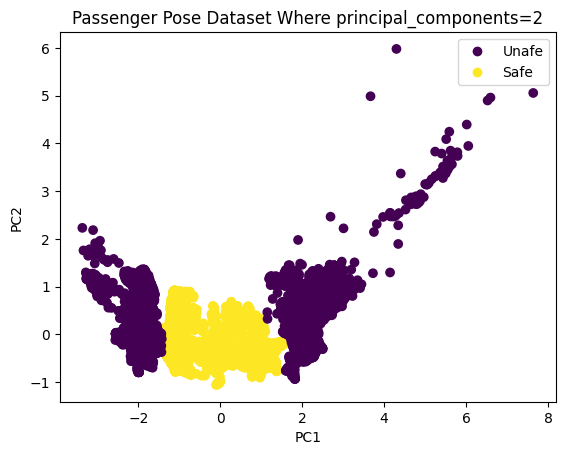

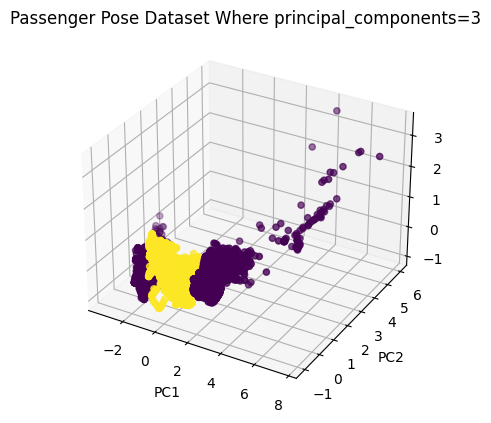

In [5]:
def plot_PCA(n_dim, X, y):
    '''
    Runs Principal Component Analysis on the dataset for visualization purposes.
    '''
    pca = PCA(n_components=n_dim)
    X_p = pca.fit_transform(X)
    if n_dim == 2:
        plot = plt.scatter(X_p[:,0], X_p[:,1], c=y)
        plt.legend(handles=plot.legend_elements()[0], labels=["Unafe", "Safe"])
    else:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X_p[:,0], X_p[:,1], X_p[:,2], c=y)

    plt.title(f"Passenger Pose Dataset Where principal_components={n_dim}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.savefig(f"dataset_visualized_{n_dim}dim")
    plt.show()

plot_PCA(2, prfc.pdata.X, prfc.pdata.y)
plot_PCA(3, prfc.pdata.X, prfc.pdata.y)

The above figures represent the principal components of the data when the number of dimensions go from 54 to 2. The scatter plot points truly make sense from this prospective. The yellow points represent safe poses-- these poses are directly in front of the camera not leaning much out of the cart or staying inside the cart. The purple points represent unsafe poses, which are on either ends of the safe poses.


## Model Analysis
### Model Analysis Background
When selecting a model for this problem, I wanted to account for simplicity, accuracy, and training speed. There were many models I considered utilizing such as Naive Bayes, DecisionTree, KNN, Neural Networks, but RandomForestClassifier caught my attention the most and provided more advantages than disadvantages for this problem. RandomForestClassifier is an ensemble ML model, and to put it in simple terms, it's just a collection of DecisionTrees. Since the data itself is set up to be a binary classification problem, DecisionTrees take advantage of this greatly due to how split points are selected and how it can easily take advantage of entropy calculations, since there are only two labels.

Not only is the nature of the problem good for DecisionTrees, but explainability for a DT is very easy; it's a simple and effective model. Also, the training speed for this RandomForestClassifier is very quick and is great for a ROS environment where passenger detection needs to happen as close to instantaneously as possible.

### Hyperparameter Tuning

There are two hyperparameters for RandomForestClassifiers: max_depth (max_depth of any DecisionTree) and n_estimators (number of DecisionTrees in forest). In order to visualize the optimal hyperparameter values to help prevent overfitting, I will be preforming a variation of K-fold cross validation called StratifiedKFold cross validation, which accounts for class label imbalance by keeping an equal precentage of classes for training and testing represented in the dataset.
<div>
<img src=https://amueller.github.io/aml/_images/stratified_cv.png style="width: 250px; height: 250px">
</div>

Train shape:  (15806, 54)
Test shape:  (7904, 54)
Train shape:  (15807, 54)
Test shape:  (7903, 54)
Train shape:  (15807, 54)
Test shape:  (7903, 54)
(19, 9, 3)
[21.34362348 21.23244338 21.62469948]
(19, 9)
21.400255446308076


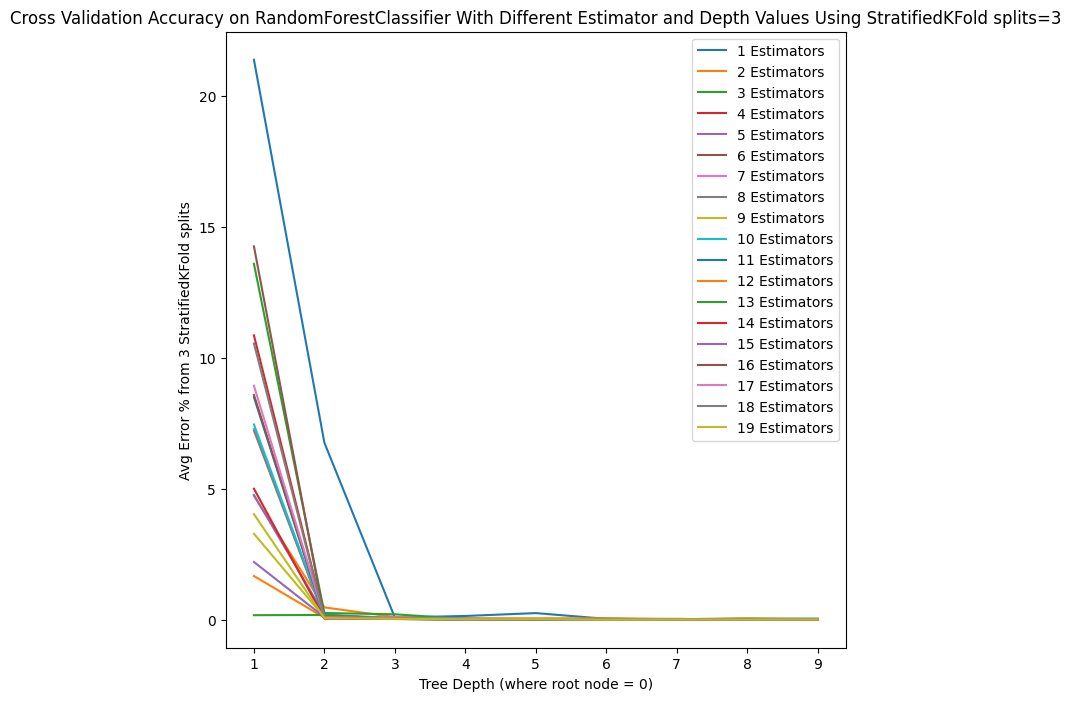

In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test) # mean accuracy

n_splits = 3
tot_estimators = 19
tot_depth = 9
kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
estimator_avg_error =  np.zeros((tot_estimators,tot_depth,n_splits), dtype=float)
split_i = 0

for train_index, test_index in kf.split(prfc.pdata.X, prfc.pdata.y):
    X_train, X_test = prfc.pdata.X[train_index], prfc.pdata.X[test_index]
    y_train, y_test = prfc.pdata.y[train_index], prfc.pdata.y[test_index]
    print("Train shape: ", X_train.shape)
    print("Test shape: ", X_test.shape)

    for estimator_i in range(1, tot_estimators + 1):
        for depth_i in range(1, tot_depth + 1):
            estimator_avg_error[estimator_i - 1][depth_i - 1][split_i] = \
                (1 - get_score(RandomForestClassifier(n_estimators=estimator_i, max_depth=depth_i, criterion="entropy"), X_train, X_test, y_train, y_test)) * 100
    split_i+=1

print(estimator_avg_error.shape)
print(estimator_avg_error[0][0])

estimator_avg_error = np.mean(estimator_avg_error, axis=2) # takes the average of all n_splits mean avg value at each depth

print(estimator_avg_error.shape)
print(estimator_avg_error[0][0])

plt.figure(figsize=(8,8))
plt.plot(np.arange(start=1, stop=tot_depth + 1), estimator_avg_error.T) # plot by column
plt.xlabel('Tree Depth (where root node = 0)')
plt.ylabel(f'Avg Error % from {n_splits} StratifiedKFold splits')
plt.title(f'Cross Validation Accuracy on RandomForestClassifier With Different Estimator and Depth Values Using StratifiedKFold splits={n_splits}')
plt.legend(labels=[f"{i + 1} Estimators" for i in range(0, tot_estimators)])
plt.savefig("KFoldHyperparamChart")
plt.show()

In [7]:
# runs sklearn's cross validation score on current model used in PassengerRFClassifier (using StratifiedKFold n = 5 for splits)
print(cross_val_score(prfc, prfc.pdata.X, prfc.pdata.y, cv=StratifiedKFold(n_splits=5, shuffle=True)).mean())

0.9973850695908899


### The RandomForest DecisionTrees
After tuning the hyperparameter values, I've decided to have 5 trees in the forest and a max_depth of 2 (where depth=0 is root node). Based on the cross_val_score from the above code block, it appears that the model will generalize well -- meaning we can expect unseen data to be predicted mostly correct -- given the very high cross_val_score. Below, the figure depicts each of the decision trees used in the passenger classification process.

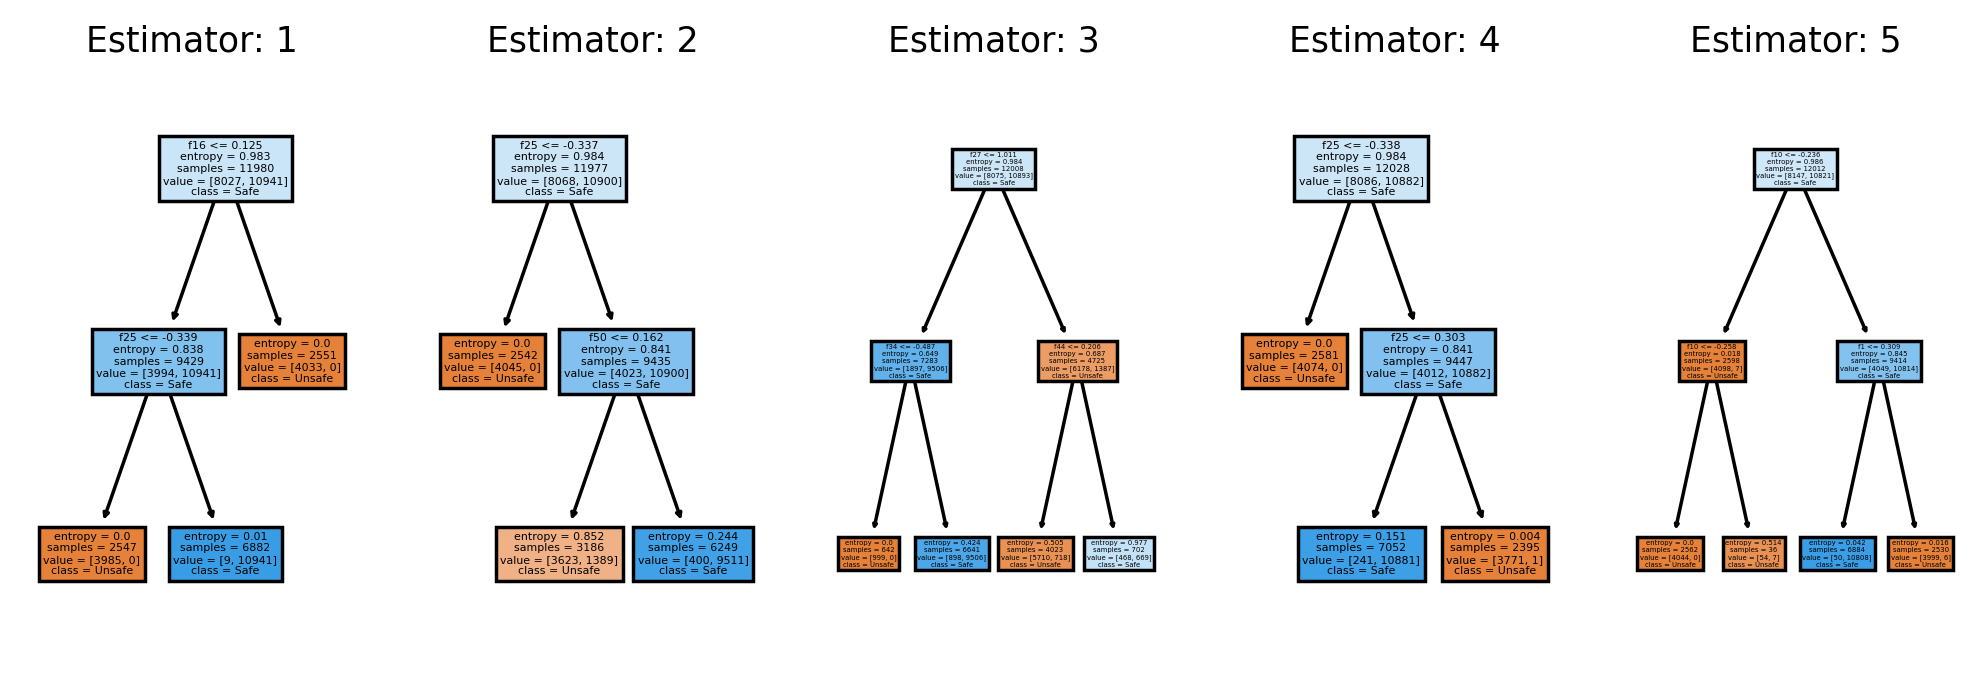

In [8]:
def plot_random_forest_trees():
    '''
    Plots out all the decision trees used in the ensemble learning for the RandomForestClassifier.
    '''
    fig, axes = plt.subplots(nrows = 1,ncols = prfc.n_estimators,figsize = (10,3), dpi=250)
    for index in range(prfc.n_estimators):
        tree.plot_tree(prfc.estimators_[index],
                    feature_names = [f"f{i}" for i in range(54)], 
                    class_names= ["Unsafe", "Safe"],
                    filled = True,
                    ax = axes[index])

        axes[index].set_title('Estimator: ' + str(index + 1), fontsize = 10)
    fig.savefig(f'rf_{prfc.n_estimators}trees.png')
    plt.show()

plot_random_forest_trees()

### Runtime Preformance

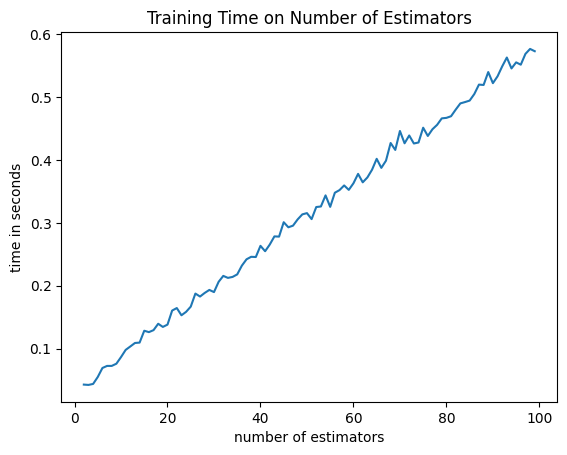

In [10]:
### Runtime Preformance
import time
time_arr = []
for i in range(2, 100):
    start = time.time()
    model_i = PassengerRFClassifier(n_estimators=i)
    model_i.fit(model_i.X_train, model_i.y_train)
    end = time.time()
    time_arr.append(end - start)

plt.plot([i for i in range(2, 100)], time_arr)
plt.ylabel("time in seconds")
plt.xlabel("number of estimators")
plt.title("Training Time on Number of Estimators")
plt.savefig("traintime_analysis.png")
plt.show()

### Confusion Matrix

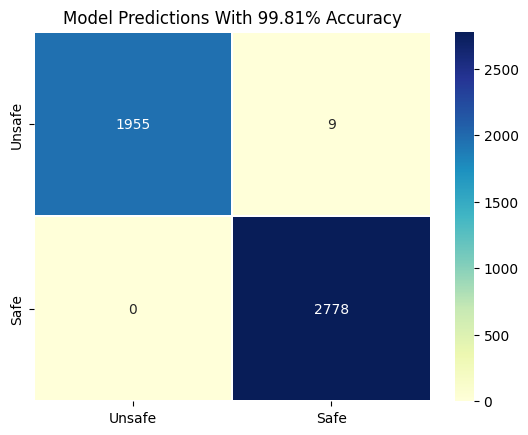

In [11]:
confusion_matrix = sklearn.metrics.confusion_matrix(prfc.y_test, y_pred)
conf_df = pd.DataFrame(confusion_matrix, index=["Unsafe", "Safe"], columns=["Unsafe", "Safe"])
heatmap = sns.heatmap(conf_df, annot=True, fmt="d", linewidths=0.35, cmap="YlGnBu")
plt.title(f"Model Predictions With {(np.sum(confusion_matrix.diagonal()) / prfc.y_test.shape[0]) * 100:.2f}% Accuracy")
plt.savefig("confusion_matrix")

### Predicting Safety on Person Outside Training Data [with version 3/09/2023, this measure doesn't make sense since Jake is in the training data]

(array([1896, 1897, 2254, 2255, 5598, 5599, 5612, 5613, 5614, 5615, 5616,
       5617, 5618, 5619, 6206, 6282, 6293, 6300, 6301, 6305, 6306],
      dtype=int64),)


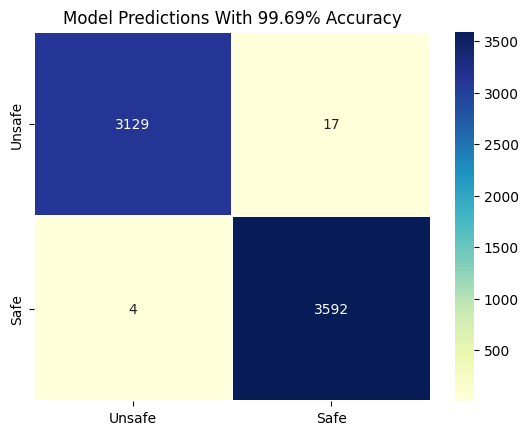

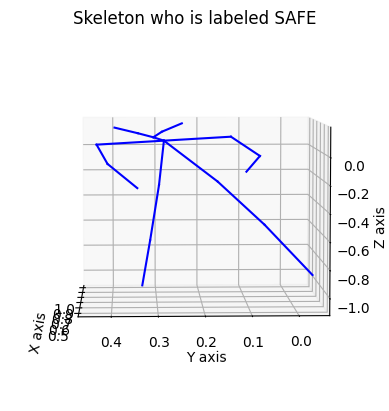

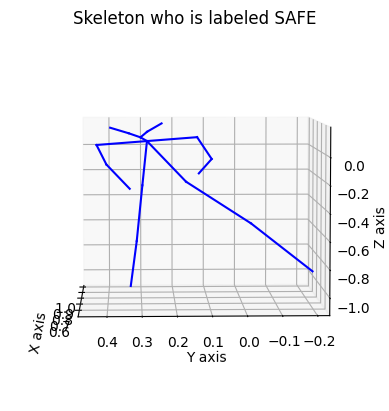

In [ ]:

y_test_jake = np.concatenate((np.load("./passenger_ML_data/jake_data/in_bounds_y_data_jake.npy"), 
                                                                   np.load("./passenger_ML_data/jake_data/out_bounds_y_data_jake.npy")))
X_pred_jake = np.concatenate(((np.load("./passenger_ML_data/jake_data/in_bounds_X_data_jake.npy"),np.load("./passenger_ML_data/jake_data/out_bounds_X_data_jake.npy"))))

X_pred_jake = np.reshape(X_pred_jake, (6742, 54))

confusion_matrix_jake = sklearn.metrics.confusion_matrix(y_test_jake, prfc.predict(X_pred_jake))
conf_df = pd.DataFrame(confusion_matrix_jake, index=["Unsafe", "Safe"], columns=["Unsafe", "Safe"])
heatmap = sns.heatmap(conf_df, annot=True, fmt="d", linewidths=0.35, cmap="YlGnBu")
plt.title(f"Model Predictions With {(np.sum(confusion_matrix_jake.diagonal()) / y_test_jake.shape[0]) * 100:.2f}% Accuracy")
plt.savefig("confusion_matrix")

print(np.where(np.not_equal(prfc.predict(X_pred_jake), y_test_jake)))

plot_skeleton(X_pred_jake, y_test_jake, np.where(np.not_equal(prfc.predict(X_pred_jake), y_test_jake))[0][0]) # classified incorrectly
plot_skeleton(X_pred_jake, y_test_jake, np.where(np.not_equal(prfc.predict(X_pred_jake), y_test_jake))[0][1]) # classified incorrectly